In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os
project_path = os.path.expanduser('~/repos/laplace_operator_metric_graph/')
sys.path.append(project_path)
import construct_graph
import solve_laplace_operator
from helper_functions import style_plot, sequential_Newton, coeff_interp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


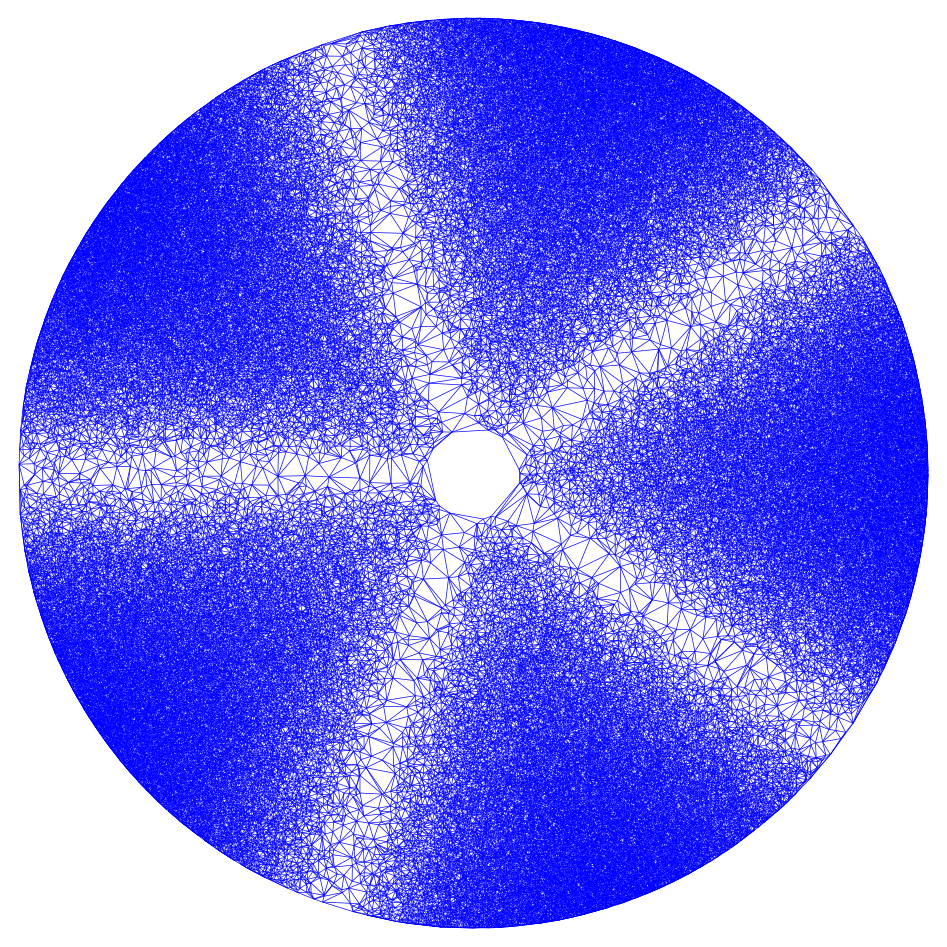

In [4]:
seed, num_Vs = 0, 200_000
np.random.seed(seed)
radial_density = lambda r: 0.02 + r**2
angular_density = lambda angular_m, theta: 0.02 + 1 + np.cos(angular_m * theta)
density = lambda r, theta, angular_m: radial_density(r) * angular_density(angular_m, theta)
angular_m = 5
g = construct_graph.random_delaunay_annulus.Random_Annulus(num_Vs, radial_density=radial_density, 
                                                           angular_density=angular_density, angular_m=angular_m,
                                                           fixed_num_points=True, num_points=3)

g.plot_graph(capstyle=None)

#### Load eigenmode data

In [ ]:
with open("../data/inhomogeneous_random_delaunay_eigenmode_pairs.pkl", "rb") as file:
    eigenvector_pairs = pickle.load(file)

with open("../data/inhomogeneous_random_delaunay_pde_coords.pkl", "rb") as file:
    pde_coords = pickle.load(file)

with open("../data/inhomogeneous_random_delaunay_pde_modes.pkl", "rb") as file:
    pde_modes = pickle.load(file)

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

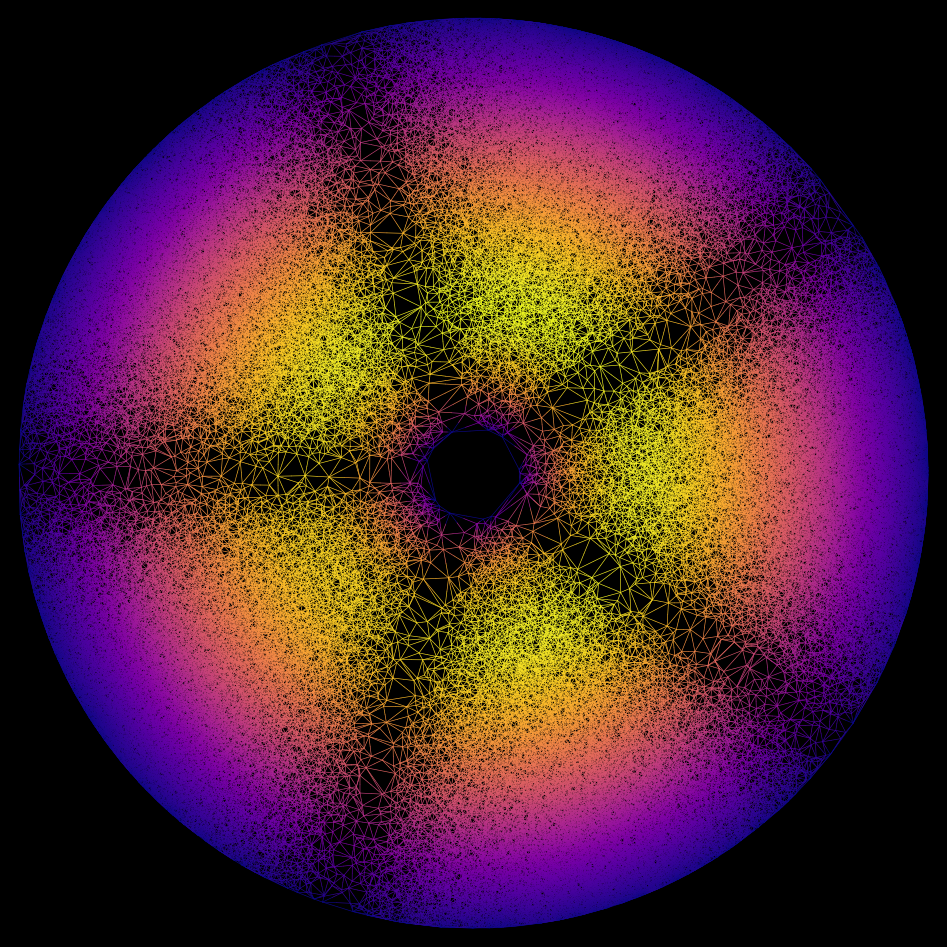

In [ ]:
pair_number = 0

graph_eigenfunction_data = solve_laplace_operator.solve_laplace_operator_update.Graph_Eigenfunctions(g, [eigenvector_pairs[pair_number]])
graph_eigenfunction = graph_eigenfunction_data.eigenfunction_pairs["eigenfunctions"][0]

g.plot_graph(eigenmode=(-1*graph_eigenfunction).data, linewidth=0.45, return_figax=True, background_color="black")
# fig, ax = g.plot_graph(eigenmode=(-1*graph_eigenfunction).data, linewidth=0.45, return_figax=True, background_color="black")

plt.show()

In [36]:
r_pde, theta_pde = pde_coords
x, y = g.V_coords.T
r_V_coord = np.sqrt(x**2 + y**2)
theta_V_coord = np.arctan2(y, x)

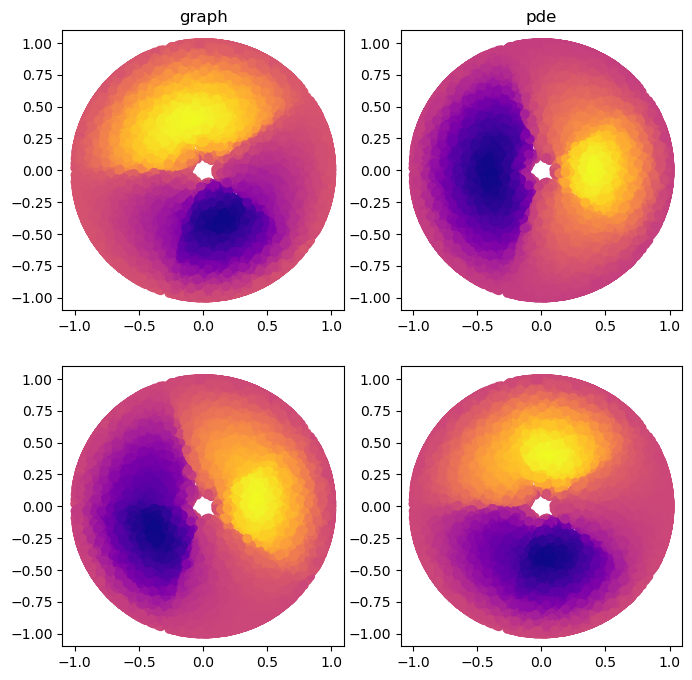

In [39]:
a, b = 1, 0 # a is pde eigen number, b=0,1
ftheta, fr = pde_modes[a][b]
pde_sol0 = np.outer(fr, ftheta)
dd = coeff_interp(pde_sol0, r_pde, 32)
pde_mode0 = dd(r_V_coord, theta_V_coord)
pde_mode0 /= np.linalg.norm(pde_mode0)

b = 1 # b=0,1
ftheta, fr = pde_modes[a][b]
pde_sol1 = np.outer(fr, ftheta)
dd = coeff_interp(pde_sol1, r_pde, 32)
pde_mode1 = dd(r_V_coord, theta_V_coord)
pde_mode1 /= np.linalg.norm(pde_mode1)

c = 1 # c is graph eigen number
graph_mode0 = np.zeros((g.num_Vs))
graph_mode0[g.interior_V_num] = eigenvector_pairs[c][1].flatten()

c = 2 # c is graph eigen number
graph_mode1 = np.zeros((g.num_Vs))
graph_mode1[g.interior_V_num] = eigenvector_pairs[c][1].flatten()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].scatter(x, y, c=graph_mode0, cmap="plasma")
ax[0,0].set_title("graph")
ax[1,0].scatter(x, y, c=graph_mode1, cmap="plasma")
ax[0,1].scatter(x, y, c=pde_mode0, cmap="plasma")
ax[0,1].set_title("pde")
ax[1,1].scatter(x, y, c=pde_mode1, cmap="plasma")

plt.show()

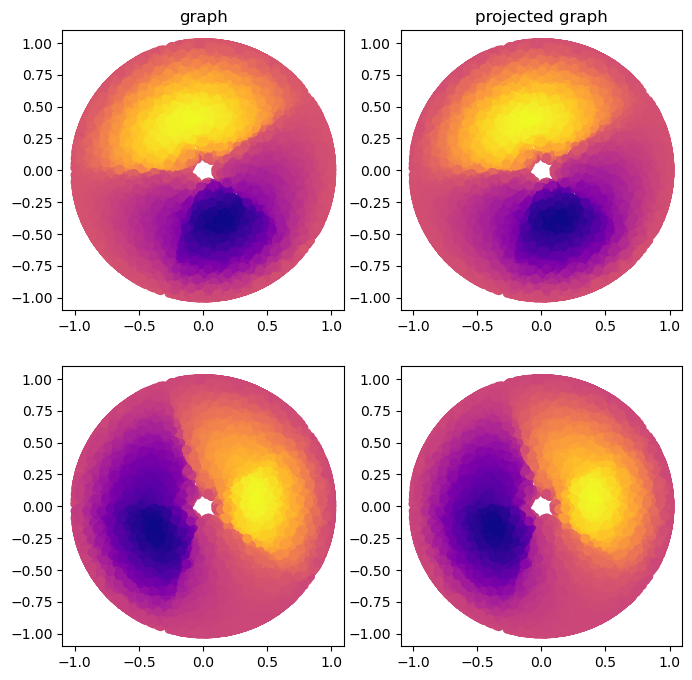

In [40]:
projected_graph_mode0 = (np.sum(graph_mode0 * pde_mode0) * pde_mode0
                       + np.sum(graph_mode0 * pde_mode1) * pde_mode1)

projected_graph_mode1 = (np.sum(graph_mode1 * pde_mode0) * pde_mode0
                       + np.sum(graph_mode1 * pde_mode1) * pde_mode1)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].scatter(x, y, c=graph_mode0, cmap="plasma")
ax[0,0].set_title("graph")
ax[1,0].scatter(x, y, c=graph_mode1, cmap="plasma")
ax[0,1].scatter(x, y, c=projected_graph_mode0, cmap="plasma")
ax[0,1].set_title("projected graph")
ax[1,1].scatter(x, y, c=projected_graph_mode1, cmap="plasma")

plt.show()

In [41]:
print(np.linalg.norm(graph_mode0 - projected_graph_mode0))
print(np.linalg.norm(graph_mode1 - projected_graph_mode1))

0.04604352060950425
0.0475285530090965


#### Eigenfunction errors:
#### For 0: $$0.041769$$
#### For 1: $$0.04604, 0.04752$$
#### For 2: $$0.05431, 0.05147$$